In [1]:
import pandas as pd
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import copy
import os
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42


Bad key "text.kerning_factor" on line 4 in
/lustre/user/lulab/doushq/wuxk/software/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
ErrorRate_df = pd.read_csv("../Results/ErrorRate_tmp.csv",index_col=0)

### optimal and nonoptimal codon detection
codon_index_df = pd.read_csv("../Data/CodonIndex_Flybase.csv",sep="\t")
codon_index_df.rename(columns={codon_index_df.columns[0]: 'codon'}, inplace=True)

tmp_df = ErrorRate_df.copy()
tmp_df.head(2)

,Intensity 0_2h_1,Intensity 0_2h_2,Intensity 0_2h_3,Intensity 0_2h_4,Intensity 10_12h_1,Intensity 10_12h_2,Intensity 10_12h_3,Intensity 10_12h_4,Intensity 18_20h_1,Intensity 18_20h_2,...,Intensity p5_3,Intensity p5_4,Intensity vf_female_1,Intensity vf_female_2,Intensity vf_female_3,Intensity vf_female_4,Intensity vf_male_1,Intensity vf_male_2,Intensity vf_male_3,Intensity vf_male_4
TTT,0.000949,0.000000,0.002160,0.000000,0.001580,0.000060,0.000043,0.000064,0.000009,0.000049,...,0.000038,0.000044,0.000008,0.000008,0.000014,0.000050,0.0,0.000012,0.000018,0.000017
TTC,0.000025,0.000009,0.000107,0.000155,0.000077,0.000014,0.000043,0.000011,0.000086,0.000005,...,0.000005,0.000206,0.000077,0.000000,0.000007,0.000002,0.0,0.000017,0.000000,0.000009


In [3]:
samplename = 'Intensity 0_2h_1'
test_df = tmp_df[[samplename]].reset_index()
test_df.columns = ['codon','errorRate']
test_index_df = pd.merge(test_df,codon_index_df,on='codon')

#
optimal_count = test_index_df['category'].value_counts()['optimal']
nonoptimal_count = test_index_df['category'].value_counts()['nonoptimal']
test_index_nonZero = test_index_df[test_index_df['errorRate']>0]
optimalNon_count = test_index_nonZero['category'].value_counts()['optimal']
nonoptimalNon_count = test_index_nonZero['category'].value_counts()['nonoptimal']
optimalNon_Ratio = optimalNon_count/optimal_count
nonoptimalNon_Ratio = nonoptimalNon_count/nonoptimal_count

removed_codons = ['ATG','TGG']
codon_index_df = codon_index_df[~codon_index_df['codon'].isin(removed_codons)]

In [4]:
samplename_list = []
optimalNon_Ratio_list = []
nonoptimalNon_Ratio_list = []

for samplename in tmp_df.columns:
    test_df = tmp_df[[samplename]].reset_index()
    test_df.columns = ['codon','errorRate']
    test_index_df = pd.merge(test_df,codon_index_df,on='codon')

    # 统计optimal和nonoptimal中非0的比例
    optimal_count = test_index_df['category'].value_counts()['optimal']
    nonoptimal_count = test_index_df['category'].value_counts()['nonoptimal']
    test_index_nonZero = test_index_df[test_index_df['errorRate']>0]
    optimalNon_count = test_index_nonZero['category'].value_counts()['optimal']
    nonoptimalNon_count = test_index_nonZero['category'].value_counts()['nonoptimal']
    optimalNon_Ratio = optimalNon_count/optimal_count
    nonoptimalNon_Ratio = nonoptimalNon_count/nonoptimal_count
    
    samplename_list.append(samplename)
    optimalNon_Ratio_list.append(optimalNon_Ratio)
    nonoptimalNon_Ratio_list.append(nonoptimalNon_Ratio)

In [5]:
result_df = pd.DataFrame([samplename_list,optimalNon_Ratio_list,nonoptimalNon_Ratio_list]).T
result_df.columns = ['samplename','optimal_ratio','nonptimal_ratio']
result_df.head(2)

,samplename,optimal_ratio,nonptimal_ratio
0,Intensity 0_2h_1,0.869565,0.722222
1,Intensity 0_2h_2,0.869565,0.416667


In [6]:
stats.wilcoxon(result_df['optimal_ratio'],result_df['nonptimal_ratio'],alternative='greater')

WilcoxonResult(statistic=2343.0, pvalue=4.3368508450108434e-13)

In [7]:
result_melt = pd.melt(result_df,id_vars='samplename',value_vars=['optimal_ratio','nonptimal_ratio'])
result_melt.columns = ['samplename','type','ratio']


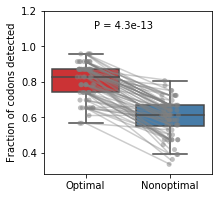

In [8]:
gray_colors = [(0.5, 0.5, 0.5)] * 68

gray_palette = sns.color_palette(gray_colors)

plt.figure(figsize=(3,3))
sns.boxplot(x='type',y='ratio',data=result_melt,showfliers=False,palette='Set1')
sns.stripplot(x="type", y="ratio", data=result_melt, color="gray",alpha=0.5)
sns.lineplot(x='type',y='ratio',hue='samplename',data=result_melt,palette=gray_palette,alpha=0.4)
plt.xticks([0,1],['Optimal','Nonoptimal'])
plt.ylabel("Fraction of codons detected")
plt.ylim(0.28,1.2)
plt.xlabel("")
plt.text(0.1,1.1,"P = 4.3e-13")
plt.legend().remove()

### Detection Simulation

In [9]:
""" R Script
gt <- function(x) {return(sum(x > 0))}

exp <- read.table("CodonIndex_Flybase_202212.csv", header=T)
exp$codon <- as.character(rownames(exp))
exp -> exp2

for(cov in seq(5*10^4, 5*10^6, 5*10^4)){

exp2$expected <- cov/sum(exp2$CodonUsage) * exp2$CodonUsage * 2.37 * 10^(-4)

exp2[,c(6:205)] <- 0
for(i in 1:nrow(exp2)){
exp2[i,c(6:205)] <- rpois(200, exp2$expected[i])}

as.numeric(apply(exp2[,c(6:205)], 2, gt)) -> ab
cat(cov, quantile(ab, 0.5), quantile(ab, 0.025), quantile(ab, 0.975), "\n")
}
""" #Save the Result into ../Results/Simulation_tmp.txt


' R Script\ngt <- function(x) {return(sum(x > 0))}\n\nexp <- read.table("CodonIndex_Flybase_202212.csv", header=T)\nexp$codon <- as.character(rownames(exp))\nexp -> exp2\n\nfor(cov in seq(5*10^4, 5*10^6, 5*10^4)){\n\nexp2$expected <- cov/sum(exp2$CodonUsage) * exp2$CodonUsage * 2.37 * 10^(-4)\n\nexp2[,c(6:205)] <- 0\nfor(i in 1:nrow(exp2)){\nexp2[i,c(6:205)] <- rpois(200, exp2$expected[i])}\n\nas.numeric(apply(exp2[,c(6:205)], 2, gt)) -> ab\ncat(cov, quantile(ab, 0.5), quantile(ab, 0.025), quantile(ab, 0.975), "\n")\n}\n'

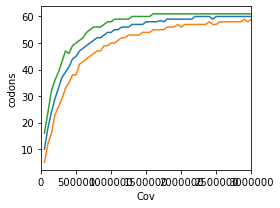

In [10]:
simResult_df = pd.read_csv("../Results/Simulation_tmp.txt",header=None,sep=' ')
simResult_df.columns = ['Cov','median','lower','upper','No']
del simResult_df['No']
simResult_melt = pd.melt(simResult_df,id_vars=['Cov'])
simResult_melt.columns = ['Cov','type','codons']

plt.figure(figsize=(4,3))
sns.lineplot(x='Cov',y='codons',hue='type',data=simResult_melt)
plt.xlim(0,3000000)
plt.legend().remove()
plt.tight_layout()